<a href="https://colab.research.google.com/github/geoburdin/core_samples/blob/master/core_samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of image classification is to assign image pixel to a cover class. Various classification approaches have been developed that assign pixels in specific ways. The choice of approach depends on:
1.	the purpose of the classification 
2.	the characteristics of the image set 
3.	the intended use of the classification results 



#Pixel based image analysis
In pixel-based classification, individual image pixels are analysed by the information that they. This is the traditional approach to classification since the pixel is the fundamental (spatial) unit of an image, and consequently it comes naturally and is often easy to implement. Various schemes are in use in pixel-based classification. 

Ideally, in pixel-based classification one uses class characterizations that are well-defined and well-separated, but reality may not always provide these. 
A fundamental limitation of pixel-based classification is that information from surrounding pixels, which may help in correctly identifying the target pixel’s class, is not used. As a consequence, a class that displays high spectral heterogeneity may have its pixels labelled as different classes. This salt-and-pepper effect is clearly unwanted. 



In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [4]:
def contours(path_to_image):
  img = cv2.imread(path_to_image)
  
  img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert to hsv
  #min and max are the boundaries which the cv2.inRange function will apply to hsv format to get an threshhold image
  #min and max are approximate and will need to be defined more precisely if accuracy of other samples is poor
  min = np.array((50, 20, 20), np.uint8)
  max = np.array((155, 140, 170), np.uint8)

  blurred = cv2.GaussianBlur(img, (21,21), 0)
  
  #locate the box using Canny edge detection operator
  canny = cv2.Canny(blurred, 100, 150, apertureSize = 3)
  pts = np.argwhere(canny>0)
  y1,x1 = pts.min(axis=0)
  y2,x2 = pts.max(axis=0)
  # crop the box
  cropped_orig = img[y1:y2, x1:x2]

  #threshold by color
  thresh = cv2.inRange(cropped_orig, min, max)
  #find the contours. Maybe useful to check other methods of approximation 
  contours0, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
  # check all contours
  for cnt in contours0:
    if len(cnt)>400:
      rect = cv2.minAreaRect(cnt) # try to set an rechtangle
      box = cv2.boxPoints(rect) # find 4 points
      box = np.int0(box) # coordinate rounding

      area = int(rect[1][0]*rect[1][1]) # area of rechtangle
      if area > 10000 and area < 500000: # if the area of rechtangle is big enough
            cv2.drawContours(cropped_orig,[box],0,(255,255,255),5) # draw it
            

  #show contours and thresh
  cropped_orig = cv2.cvtColor(cropped_orig, cv2.COLOR_HSV2RGB)
  plt.rcParams["figure.figsize"] = (20,20)
  plt.subplot(121)
  plt.imshow(cropped_orig)
  plt.title('Contours Image'), plt.xticks([]), plt.yticks([])
  plt.subplot(122)
  plt.imshow(thresh, cmap='gray')
  plt.title('thresh image'), plt.xticks([]), plt.yticks([])
  plt.show()
  
  return cropped_orig

DSC05749.JPG


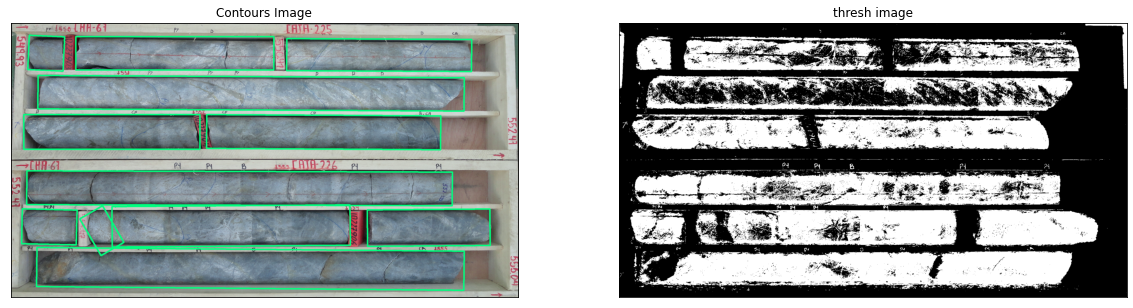

DSC05091.JPG


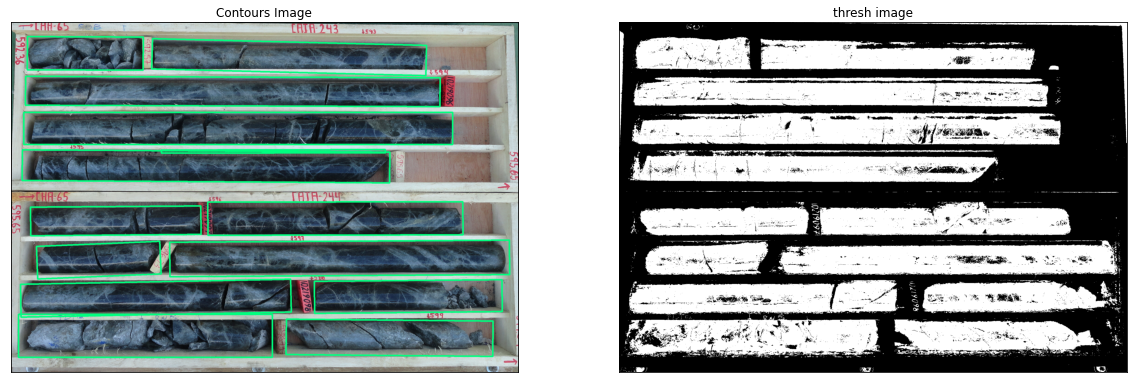

DSC05750.JPG


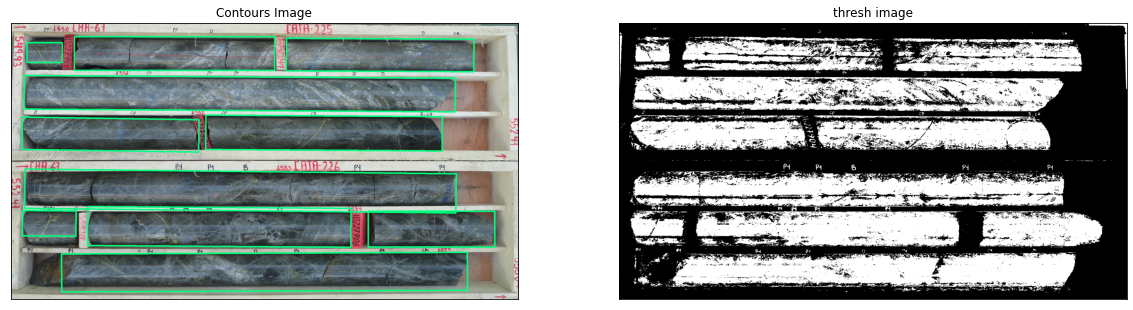

DSC05090.JPG


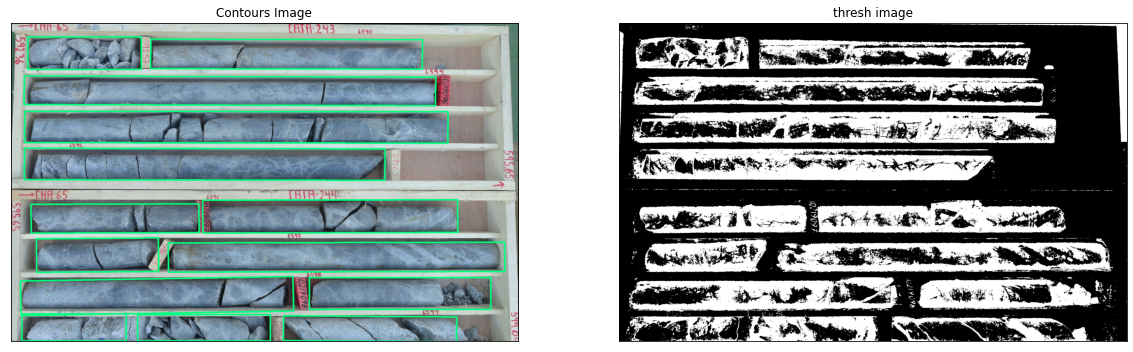

In [5]:
from pathlib import Path
images_cnt = []
mydir = Path("/content/")
for file in mydir.glob('*.JPG'):
    print(file.name)
    images_cnt.append(contours("/content/"+file.name))

#Object-based image analysis
Object-based image analysis (OBIA) is one of several approaches developed to overcome the limitations of the pixel-based approaches. It incorporates information of surrounding to identify segmentations in an image. 

The first step in OBIA is to segment the image into homogeneous objects. The term object here stands for a cluster of pixels. Segmentation is based on pre-defined parameters like compactness, shape, and scale, derived from real-world knowledge of the features that one wants to identify 

In a second step, each object (segment) is classified on the basis of one or more statistical properties of the contained pixels. This means that all pixels within a segment are assigned to one class, eliminating the within-field spectral variability and mixed pixels problems associated with pixel-based approaches. Several studies have confirmed the superiority of OBIA over pixel-based classifications, especially in heterogeneous cases


In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import img_as_float
import skimage.io
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = cv2.imread('/content/DSC05090.JPG')
blurred = cv2.GaussianBlur(img, (21,21), 0)

#locate the box using Canny edge detection operator
canny = cv2.Canny(blurred, 100, 150, apertureSize = 3)
pts = np.argwhere(canny>0)
y1,x1 = pts.min(axis=0)
y2,x2 = pts.max(axis=0)
# crop the box
img = img[y1:y2, x1:x2]


# Comparison of segmentation and superpixel algorithms
This example compares four popular low-level image segmentation methods. As it is difficult to obtain good segmentations, and the definition of “good” often depends on the application, these methods are usually used for obtaining an oversegmentation, also known as superpixels

# Felzenszwalb’s efficient graph based segmentation
This fast 2D image segmentation algorithm is popular in the computer vision community. The algorithm has a single scale parameter that influences the segment size. The actual size and number of segments can vary greatly, depending on local contrast.

# Quickshift image segmentation
Quickshift is a relatively recent 2D image segmentation algorithm, based on an approximation of kernelized mean-shift. Therefore it belongs to the family of local mode-seeking algorithms and is applied to the 5D space consisting of color information and image location 2.

One of the benefits of quickshift is that it actually computes a hierarchical segmentation on multiple scales simultaneously.

Quickshift has two main parameters: sigma controls the scale of the local density approximation, max_dist selects a level in the hierarchical segmentation that is produced. There is also a trade-off between distance in color-space and distance in image-space, given by ratio.


# SLIC - K-Means based image segmentation
This algorithm simply performs K-means in the 5d space of color information and image location and is therefore closely related to quickshift. As the clustering method is simpler, it is very efficient but it is essential for this algorithm to work in Lab color space to obtain good results. The algorithm quickly gained momentum and is now widely used.


# Compact watershed segmentation of gradient images
Instead of taking a color image as input, watershed requires a grayscale gradient image, where bright pixels denote a boundary between regions. The algorithm views the image as a landscape, with bright pixels forming high peaks. This landscape is then flooded from the given markers, until separate flood basins meet at the peaks. Each distinct basin then forms a different image segment.

In [7]:
# do segmentation multiple options
segments_fz = felzenszwalb(img, scale=200, sigma=0.5, min_size=250)
segments_slic = slic(img, n_segments=250, compactness=10)
segments_quick = quickshift(img)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers = 1000, compactness=0.000001)


#Segmentation
Image segmentation is a key component to object-based classification. Segmentation is a process by which pixels in an image are grouped into segments, objects or features, that have similar spectral and spatial characteristics. Each of these objects or features contain multiple pixels. The segments in the image ideally correspond to real-world features. 
There are a variety of different parameters that are used in segmentation. The scale of the objects or features is one of the important variables in the image segmentation process. The scale sets the minimum number of pixels that must be contained in a group for it to be a separate segment or object.

Felzenszwalb number of segments: 731
SLIC number of segments: 179
Quickshift number of segments: 4722
Compact Watershed number of segments: 975


Text(0.5, 1.0, 'Compact watershed')

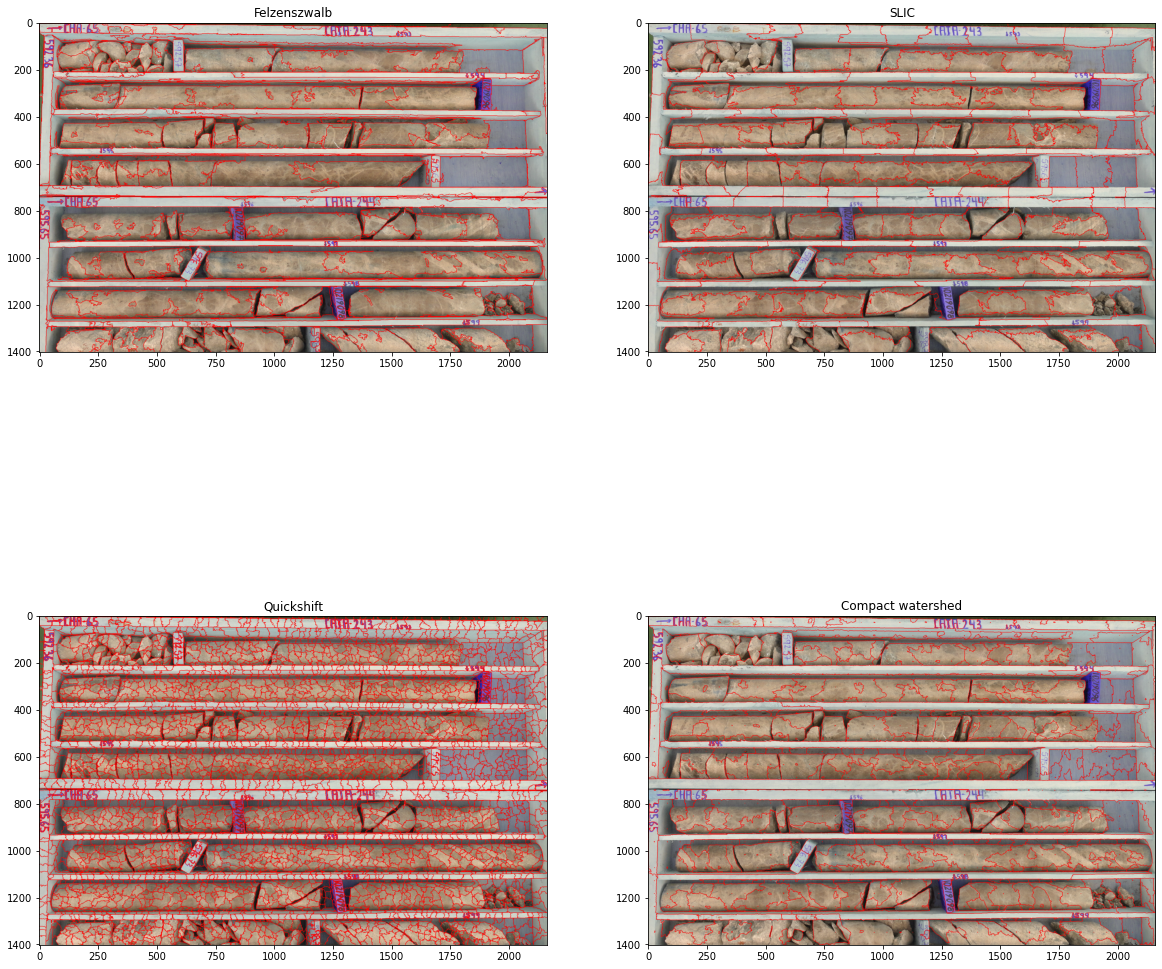

In [8]:

print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")
print(f"Compact Watershed number of segments: {len(np.unique(segments_watershed))}")

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax[0, 0].imshow(mark_boundaries(img, segments_fz, color=(1, 0, 0)))
ax[0, 0].set_title("Felzenszwalb")
ax[0, 1].imshow(mark_boundaries(img, segments_slic, color=(1, 0, 0)))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick, color=(1, 0, 0)))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed, color=(1, 0, 0)))
ax[1, 1].set_title('Compact watershed')
